## Title

**Authors:** <br>
Björn Hahn () <br>
Domenico Ferraro ()<br>
Justus Raabe (940919) <br>
Lisa Sachau (941367)

#### Imported Packages

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
import functions as func


#### Load Data

['./Fotos_einfach/manul/m3.jpg', './Fotos_einfach/manul/m2.jpg', './Fotos_einfach/manul/m1.jpg', './Fotos_einfach/manul/m5.jpg', './Fotos_einfach/manul/m4.jpg', './Fotos_einfach/manul/m6.jpg', './Fotos_einfach/manul/m10.jpg', './Fotos_einfach/manul/m7.jpg', './Fotos_einfach/manul/m9.JPG', './Fotos_einfach/manul/m8.jpg', './Fotos_einfach/tiger/t6.jpeg', './Fotos_einfach/tiger/t7.jpeg', './Fotos_einfach/tiger/t10.jpeg', './Fotos_einfach/tiger/t1.jpeg', './Fotos_einfach/tiger/t2.jpeg', './Fotos_einfach/tiger/t3.jpeg', './Fotos_einfach/tiger/t4.jpeg', './Fotos_einfach/tiger/t8.jpeg', './Fotos_einfach/tiger/t9.jpeg', './Fotos_einfach/tiger/t5.jpeg', './Fotos_einfach/lion/l1.jpeg', './Fotos_einfach/lion/l6.jpeg', './Fotos_einfach/lion/l10.jpeg', './Fotos_einfach/lion/l7.jpeg', './Fotos_einfach/lion/l4.jpeg', './Fotos_einfach/lion/l8.jpeg', './Fotos_einfach/lion/l9.jpeg', './Fotos_einfach/lion/l5.jpeg', './Fotos_einfach/lion/l2.jpeg', './Fotos_einfach/lion/l3.jpeg', './Fotos_einfach/sand cat/

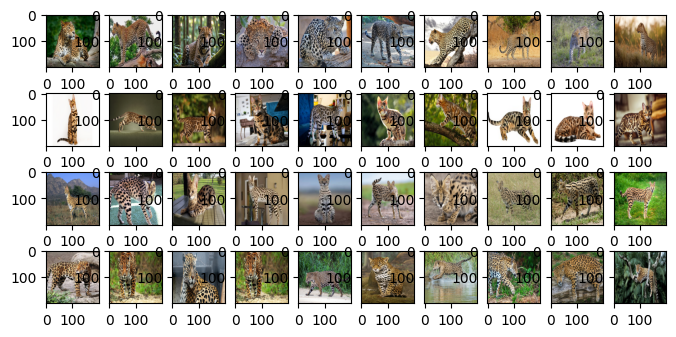

In [2]:
# Get file names
folder_e = './Fotos_einfach'
folder_h = './Fotos_schwierig'
#image_names, categories = read_image_names(filepath)
categories_e, image_names_e, labels_e = func.get_filenames_labels(folder_e)
categories_h, image_names_h, labels_h = func.get_filenames_labels(folder_h)
print(image_names_e)
print(labels_e)
print(categories_e)
print(image_names_h)
print(labels_h)
print(categories_h)
# Load images
input_shape = {
    "height": 200,
    "width": 200,
    "channels": 3
}
images_e = func.read_images(image_names_e, height=input_shape["height"], width=input_shape["width"])
images_h = func.read_images(image_names_h, height=input_shape["height"], width=input_shape["width"])
# Convert images to array
aimages_e = func.images_to_array(images_e)
aimages_h = func.images_to_array(images_h)
print(f'Shape of images array: {aimages_e.shape}')
# Plot images array
fig = plt.figure(figsize=(8, 8))
rows, columns = 8, 10
for i in range(aimages_h.shape[0]):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(aimages_h[i, ...])
plt.show()


#### Data Augmentation

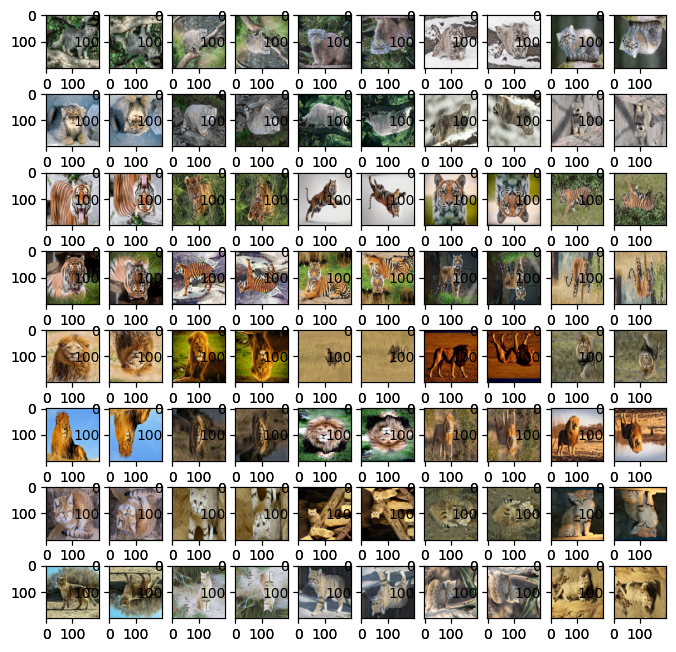

['leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard'
 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard'
 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'bengal'
 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal'
 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal'
 'bengal' 'bengal' 'bengal' 'serval' 'serval' 'serval' 'serval' 'serval'
 'serval' 'serval' 'serval' 'serval' 'serval' 'serval' 'serval' 'serval'
 'serval' 'serval' 'serval' 'serval' 'serval' 'serval' 'serval' 'jaguar'
 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar'
 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar'
 'jaguar' 'jaguar' 'jaguar']
(80,)
['leopard', 'bengal', 'serval', 'jaguar']


In [3]:
def augment_images(images, labels):
    aug_images = []
    aug_labels = []
    for i, row in enumerate(images):
        aug_images.append(images[i])
        aug_labels.append(labels[i])
        aug_images.append(np.flipud(row))
        aug_labels.append(labels[i])
    return aug_images, aug_labels

a_images_e, a_labels_e = augment_images(aimages_e, labels_e)
aug_images_e = func.images_to_array(a_images_e)
aug_labels_e = func.images_to_array(a_labels_e)
a_images_h, a_labels_h = augment_images(aimages_h, labels_h)
aug_images_h = func.images_to_array(a_images_h)
aug_labels_h = func.images_to_array(a_labels_h)

fig = plt.figure(figsize=(8, 8))
rows, columns = 8, 10
for i in range(aug_images_h.shape[0]):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(aug_images_h[i, ...])
for i in range(aug_images_e.shape[0]):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(aug_images_e[i, ...])
plt.show()
print(aug_labels_h)
print(aug_labels_h.shape)
print(categories_h)

#### Data Augmentation 2

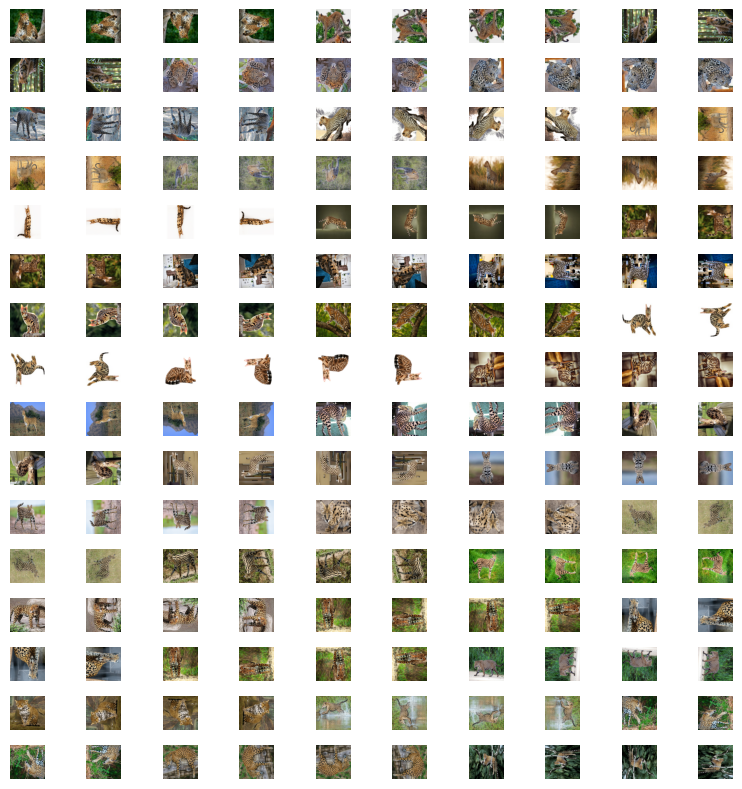

In [6]:
def augment_images_v2(images, labels):
    aug_images = []
    aug_labels = []
    for i, row in enumerate(images):
        # Original
        aug_images.append(images[i])
        aug_labels.append(labels[i])
        
        # 90 Grad Drehung (nach rechts)
        aug_images.append(np.rot90(row, k=1))
        aug_labels.append(labels[i])
        
        # 180 Grad Drehung (nach unten)
        aug_images.append(np.rot90(row, k=2))
        aug_labels.append(labels[i])
        
        # 270 Grad Drehung (nach links)
        aug_images.append(np.rot90(row, k=3))
        aug_labels.append(labels[i])
    
    return aug_images, aug_labels

# Anwenden der Augmentierung auf einfache Bilder
a_images_e_v2, a_labels_e_v2 = augment_images_v2(aimages_e, labels_e)
aug_images_e_v2 = func.images_to_array(a_images_e_v2)
aug_labels_e_v2 = func.images_to_array(a_labels_e_v2)

# Anwenden der Augmentierung auf schwierige Bilder
a_images_h_v2, a_labels_h_v2 = augment_images_v2(aimages_h, labels_h)
aug_images_h_v2 = func.images_to_array(a_images_h_v2)
aug_labels_h_v2 = func.images_to_array(a_labels_h_v2)

total_images = aug_images_h_v2.shape[0]
columns = 10
rows = int(np.ceil(total_images / columns))  # Dynamische Anzahl der Zeilen

fig = plt.figure(figsize=(8, 8))
for i in range(total_images):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.imshow(aug_images_h_v2[i, ...])
    ax.set_xticks([])  # Entfernt x-Achsen-Ticks
    ax.set_yticks([])  # Entfernt y-Achsen-Ticks
    ax.grid(False)     # Deaktiviert das Raster innerhalb der Subplots

plt.tight_layout()
plt.show()



Encode Labels

In [6]:
encoder = OneHotEncoder(categories=[categories_e], sparse_output=False)
y_e = encoder.fit_transform(np.array(aug_labels_e).reshape(-1,1))
print(y_e)
encoder = OneHotEncoder(categories=[categories_h], sparse_output=False)
y_h = encoder.fit_transform(np.array(aug_labels_h).reshape(-1,1))
print("neues Array")
print(y_h)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0.

In [21]:
#eigener OneHotEncoder
def ownOneHotEncoder(labels, categories):
    encoded_vectors = []
    for label in labels:
        vector = [1 if label == categorie else 0 for categorie in categories]
        encoded_vectors.append(vector)
    df = pd.DataFrame(encoded_vectors, columns=categories)
    encoded_labels = df.to_numpy()
    return encoded_labels

y_h = ownOneHotEncoder(aug_labels_h, categories_h)
y_h


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0,

Training and Test-Split with K-Fold (vielleicht K-Fold auch später, unsicher bei Reihenfolge tbh)

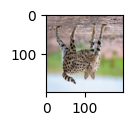

[0. 1. 0. 0.]
[0. 0. 0. 1.]


In [6]:
data_e = aug_images_e
data_h = aug_images_h
k = 4
image_folds_e, y_folds_e = func.slice_data_in_folds(data_e, y_e, k)
image_folds_h, y_folds_h = func.slice_data_in_folds(data_h, y_h, k)
fig = plt.figure(figsize=(2, 1))
plt.imshow(image_folds_e[3][2])
plt.imshow(image_folds_h[3][2])
plt.show()
print(y_folds_e[3][2])
print(y_folds_h[3][2])

#### Build Model

easy difficulty

In [8]:
epoch = 15
eval_accuracy = []
accuracy = []
for i in range(k):
    fold_x_train = np.concatenate([image_folds_e[j] for j in range(k) if j != i], axis=0)
    fold_y_train = np.concatenate([y_folds_e[j] for j in range(k) if j != i], axis=0)
    fold_x_val = image_folds_e[i]
    fold_y_val = y_folds_e[i]
    model, model_accuracy = func.build_model(epoch, fold_x_train, fold_y_train, fold_x_val, fold_y_val, input_shape, y_e)
    eval_accuracy.append(model_accuracy)
    accuracy.append(max(model.history['accuracy']))
print(eval_accuracy)
print(accuracy)

Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2708 - loss: 3440.8040
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3354 - loss: 2234.4482
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3049 - loss: 335.7983
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2833 - loss: 95.8530 
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.2715 - loss: 24.9964
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4764 - loss: 8.6153
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.3174 - loss: 4.1086
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4569 - loss: 2.5560
Epoch 9/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5340 - loss: 1.7679
Epoch 10/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7812 - loss: 0.5992
Epoch 11/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7069 - loss: 0.7318
Epoch 12/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7500 - loss: 0.6500
Epoch 13/15
2/

Plotting of Accuracy and Loss

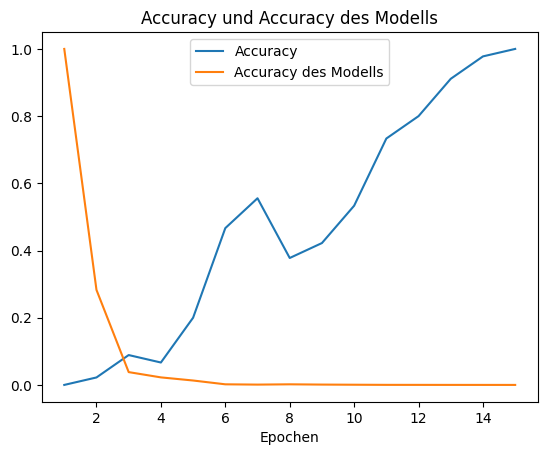

In [9]:
# noch zu überarbeiten

plt.plot(range(1, epoch+1), func.minmax(model.history['accuracy']))
plt.plot(range(1, epoch+1), func.minmax(model.history['loss']))
plt.title('Accuracy und Accuracy des Modells')
plt.xlabel('Epochen')
plt.gca().legend(('Accuracy', 'Accuracy des Modells'))
plt.show()

hard difficulty

In [9]:
epoch = 20
eval_accuracy = []
accuracy = []
for i in range(k):
    fold_x_train = np.concatenate([image_folds_h[j] for j in range(k) if j != i], axis=0)
    fold_y_train = np.concatenate([y_folds_h[j] for j in range(k) if j != i], axis=0)
    fold_x_val = image_folds_h[i]
    fold_y_val = y_folds_h[i]
    model, model_accuracy = func.build_model(epoch, fold_x_train, fold_y_train, fold_x_val, fold_y_val, input_shape, y_h)
    eval_accuracy.append(model_accuracy)
    accuracy.append(max(model.history['accuracy']))
print(eval_accuracy)
print(accuracy)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1625 - loss: 10954.5742
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.2611 - loss: 991.1694 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.2285 - loss: 291.2411
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3819 - loss: 83.5863
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3160 - loss: 25.3458
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.2722 - loss: 21.6022
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5750 - loss: 5.1708
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5215 - loss: 3.0198
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6312 - loss: 1.6962
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6743 - loss: 1.4387
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6069 - loss: 1.4136
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7812 - loss: 0.9654
Epoch 13/20
2

Plotting of Accuracy and Loss for hard difficulty

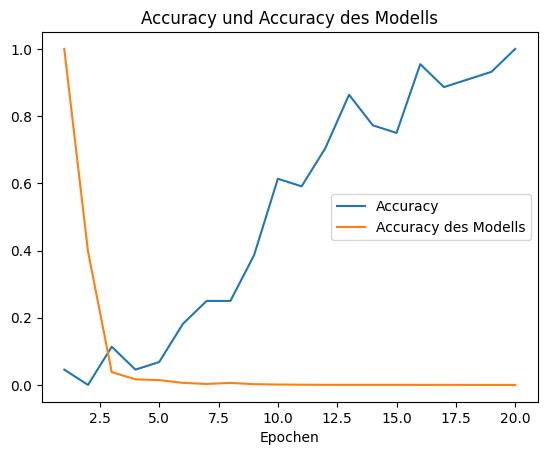

In [10]:
#auch noch zu überarbeiten
plt.plot(range(1, epoch+1), func.minmax(model.history['accuracy']))
plt.plot(range(1, epoch+1), func.minmax(model.history['loss']))
plt.title('Accuracy und Accuracy des Modells')
plt.xlabel('Epochen')
plt.gca().legend(('Accuracy', 'Accuracy des Modells'))
plt.show()

Prediction

In [ ]:
#prediction here